# Statistical error propagation

In [1]:
from radiocalibrationtoolkit import *
from IPython.display import Markdown as md

[INFO] LFmap: Import successful.


In [2]:
# some global plot settings
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = 16
plt.rcParams["legend.fontsize"] = 14

plt.rcParams["xtick.major.width"] = 2
plt.rcParams["ytick.major.width"] = 2

plt.rcParams["xtick.major.size"] = 5
plt.rcParams["ytick.major.size"] = 5

plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14

In [3]:
# create class instances
galactic_map_inst = GlobalSkyModel2016(freq_unit="MHz")
antenna_inst = AntennaPattern("./antenna_setup_files/SALLA_EW.xml")

# some constants
update_antenna_conventions = {
    "shift_phi": -90,
    "flip_theta": True,
    "flip_phi": False,
    "in_degrees": True,
    "add_invisible_sky": True,
}
LATITUDE = -35.206667
NSIDE = 64


[INFO] Your keys are: ['EAHTheta_amp', 'EAHTheta_phase', 'EAHPhi_amp', 'EAHPhi_phase', 'absolute'] Use them as the 'quantity'


In [4]:
# first part of this examples will use this frequency and LST
frequency_MHz = 45
lst = 22

In [5]:
# create maps
rotation_parameters = create_rotation_parameters(lst, LATITUDE)
rotator = Rotator(coord=["G", "C"], rot=rotation_parameters)

antenna_map_inst = antenna_inst.convert2hp(
    frequency=frequency_MHz, quantity="absolute", **update_antenna_conventions
)
antenna_map = antenna_map_inst.get_map(rotator=rotator)

galactic_map = hp.ma(
    hp.pixelfunc.ud_grade(galactic_map_inst.generate(frequency_MHz), NSIDE)
).copy()
galactic_map.mask = create_local_mask(NSIDE, rotation_parameters)

## Propagation to effective temperature and voltage squared spectral denisty

In [6]:
# set up the relative standard deviations on galactic emission and the antenna gain
rstd_galactic_map = 0.5
rstd_antenna_map = 0.

### Error propagation from sky temperature and antenna gain to effective temperature

In [7]:
# analytical calculation
rstd_teff = np.sqrt(rstd_galactic_map**2 + 4*rstd_antenna_map**2)


 \begin{equation}
\rho_{T\mathrm{eff}}(t,f,\alpha,\delta) = \frac{\sigma_{T\mathrm{eff}}(t,f,\alpha,\delta)}{T_{\mathrm{eff}}(t,f,\alpha,\delta)} = \sqrt{ \rho_{T}^2(t,\alpha,\delta) + 4 \rho_H^2 (t,f,\alpha,\delta) 	}
\end{equation}


In [8]:
# experimental test by distorting the galactic and antenna maps
r = (
    distort_array(galactic_map, rstd_galactic_map)
    * distort_array(antenna_map, rstd_antenna_map) ** 2
) / (galactic_map * antenna_map**2)

In [9]:
# compare
print('Experimentally propagated: {:.2f}'.format(np.std(r)))
print('Analytical calculation: ', rstd_teff)

Experimentally propagated: 0.50
Analytical calculation:  0.5


/home/tomas/.local/lib/python3.10/site-packages/healpy/newvisufunc.py:398: UserWarning: 
 *** Overriding default plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.01, 'cbar_label_pad': 8, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 10, 'figure_size_ratio': 0.63} ***
  warnings.warn(
/home/tomas/.local/lib/python3.10/site-packages/healpy/newvisufunc.py:402: UserWarning: 
 *** New plot properies: {'cbar_shrink': 1, 'cbar_pad': 0.01, 'cbar_label_pad': 8, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 10, 'figure_size_ratio': 0.63} ***
  warnings.warn("\n *** New plot properies: " + str(plot_properties) + " ***")


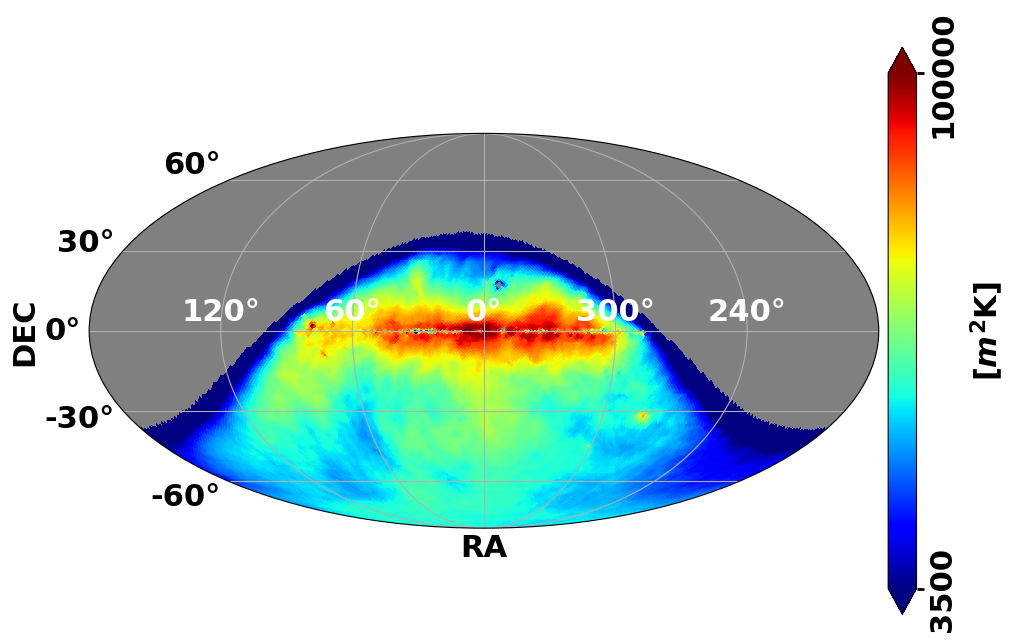

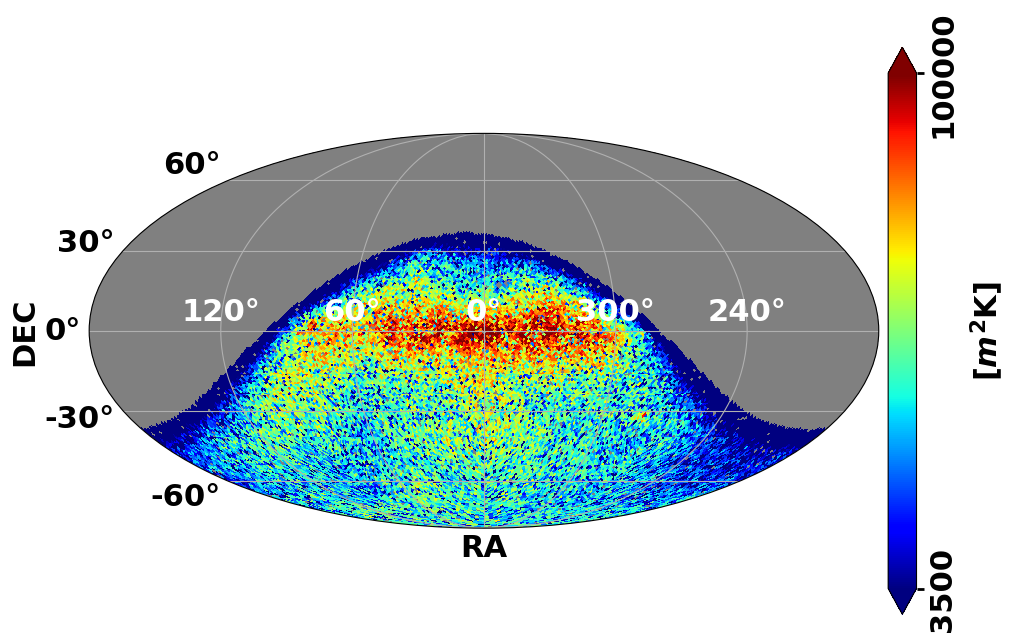

In [10]:
# just a plot comparison of how the distorted effective temperature by 50% looks like
teff = galactic_map * antenna_map**2
teff_distored = distort_array(teff, rstd=rstd_teff)

fontsize = {
    "xlabel": 22,
    "ylabel": 22,
    "title": 14,
    "xtick_label": 22,
    "ytick_label": 22,
    "cbar_label": 22,
    "cbar_tick_label": 22,
}

for m in [teff, teff_distored]:
    projview(
        m,
        cmap="jet",
        min=3500,
        max=100000,
        norm="log",
        graticule=True,
        graticule_labels=True,
        unit="[$m^2$K]",
        xlabel="RA",
        ylabel="DEC",
        cb_orientation="vertical",
        latitude_grid_spacing=30,
        xtick_label_color="white",
        title='',
        override_plot_properties={'cbar_shrink':1},
        fontsize=fontsize
    )


### Integrated effective temperature and the voltage square spectral density

- this is done in loop 100x

In [11]:
def propagate_errors(rstd_teff, rstd_galactic_map, rstd_antenna_map):
    # calculate the effective temperature
    teff = galactic_map * antenna_map**2

    ratios_teff = np.array([])
    for i in range(100):
        # teff_distored = distort_array(teff, rstd=rstd_teff)
        teff_distored = (
            distort_array(galactic_map, rstd_galactic_map)
            * distort_array(antenna_map, rstd_antenna_map) ** 2
        )
        ratios_teff = np.append(
            ratios_teff, integrate_hpmap(teff) / integrate_hpmap(teff_distored)
        )

    # do the same with voltage square density, this should give the same results as before (more-less)
    # this is to check that there the extra constants have no effect
    ratios_v2sp = np.array([])
    v2sp = voltage_squared_spectral_density(antenna_map, galactic_map, frequency_MHz)

    for i in range(100):
        galactic_map_distorted = distort_array(galactic_map, rstd_galactic_map)
        antenna_map_distorted = distort_array(antenna_map, rstd_antenna_map)

        v2sp_distorted = voltage_squared_spectral_density(
            antenna_map_distorted, galactic_map_distorted, frequency_MHz
        )

        ratios_v2sp = np.append(ratios_v2sp, v2sp / v2sp_distorted)

    # figure
    fig, ax = plt.subplots()
    bins = np.histogram_bin_edges(np.concatenate([ratios_teff, ratios_v2sp]), bins=20)
    ax.set_title(
        "Error on sky temperature: {:.2f}, error on antenna gain: {:.2f}".format(
            rstd_galactic_map, rstd_antenna_map
        )
    )

    ax.hist(
        ratios_teff,
        bins=bins,
        alpha=0.5,
        label=r"T$_{{\mathrm{{eff}}}}$: Mean={:.2f}, Std={:.1e}".format(
            np.mean(ratios_teff), np.std(ratios_teff)
        ),
    )
    ax.hist(
        ratios_v2sp,
        bins=bins,
        alpha=0.5,
        label=r"V$^2_f$: Mean={:.2f}, Std={:.1e}".format(
            np.mean(ratios_v2sp), np.std(ratios_v2sp)
        ),
    )
    ax.legend()

From the histograms bellow we conclude two things:

- there is virtually no effect of the constants on the relative error propagation (as expected)
- the error on the antenna gains is causing a bias, i.e. the whole distributions is shifted

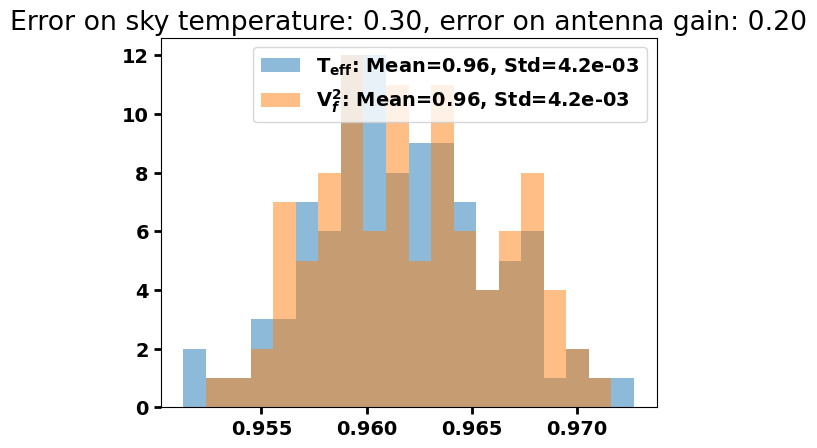

In [12]:
propagate_errors(rstd_teff=0.5, rstd_galactic_map=0.3, rstd_antenna_map=0.2)

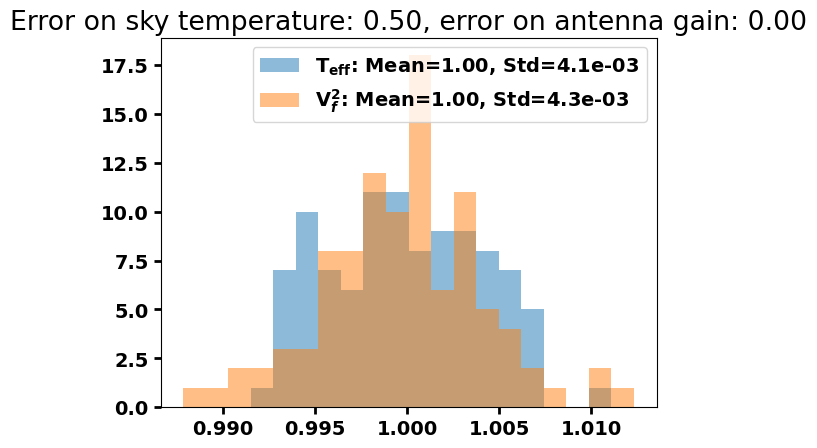

In [13]:
propagate_errors(rstd_teff=0.5, rstd_galactic_map=0.5, rstd_antenna_map=0.)

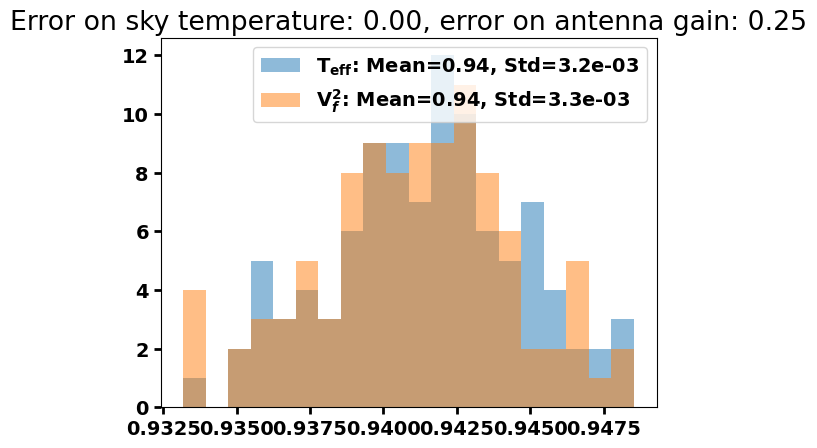

In [14]:
propagate_errors(rstd_teff=0.5, rstd_galactic_map=0., rstd_antenna_map=0.25)

### Analytical calculations of the error propagation to the integrated sky temperature

We attempt to calculate the following equation other assumption of isotropic effective temperature distorted by 50%

  \begin{equation}
\rho_{G\mathrm{sky}} (t,f) = \sqrt{ \frac{\sum_{\delta}  \sin^2{\delta}  }{N_{\alpha} \left( \sum_{\delta} \sin{\delta} \right)^2} } \rho_{T\mathrm{eff}}(t,f,\alpha,\delta)
\end{equation}

In [15]:
# check what is the size of the theta and phi when integrating (should be 1000x500)
# so, for half sphere it is 1000x250
# check the value of the propagated error at 250 then
PHI, THETA, grid_map = hpmap2grid(galactic_map)
phi_delta = abs(np.diff(PHI[0, :])[0])
phi_theta = abs(np.diff(THETA[:, 0])[0])
print(PHI[0, :].size, THETA[:, 0].size)

1000 500


In [16]:
propagated_err_analytical = np.array([])

Ns = [10, 100, 250, 500, 1000, 10000, 50000, 100000]
for N in Ns:
    sum_1 = 0
    sum_2 = 0 
    for x in np.linspace(0, np.pi/2, N):
        sum_1 += np.sin(x)**2
        sum_2 += np.sin(x)

    propagated_err_analytical = np.append(propagated_err_analytical, np.sqrt(sum_1/sum_2**2 /(N*4))*rstd_teff)
    
print(propagated_err_analytical)
    

[2.84434355e-02 2.78283164e-03 1.11167868e-03 5.55599290e-04
 2.77739844e-04 2.77686143e-05 5.55362751e-06 2.77680780e-06]


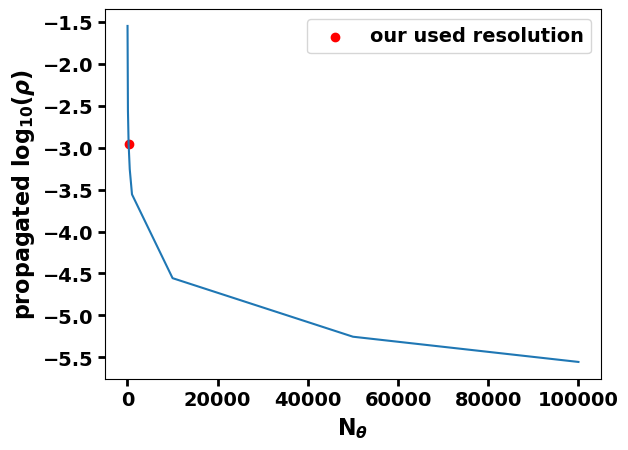

In [17]:
fig, ax = plt.subplots()
ax.plot(Ns, np.log10(propagated_err_analytical))
ax.scatter(Ns[2], np.log10(propagated_err_analytical)[2], c='r', label='our used resolution')
ax.set_xlabel('N$_{\\theta}$')
ax.set_ylabel('propagated log$_{10}$($\\rho$)')
ax.legend()

## Propagation to the power

In [18]:
# check the propagation to the finally calculated power at a range of LST and frequency values
lst_range = np.asarray(list(range(24))) + 0.5
freq_Mhz_range = range(30, 81, 1)

hw_file_path = "./antenna_setup_files/HardwareProfileList_realistic.xml"
hw_dict = read_hw_file(hw_file_path, interp_args={'fill_value':'extrapolate'})

<?xml version="1.0" encoding="iso-8859-1"?>
<Element HardwareProfileList at 0x7f9a4dfd9040>


In [19]:
def propagated_errors_2_power(rstd_antenna_map=0.2, rstd_galactic_map=0.3):

    lst_range = np.asarray(list(range(24))) + 0.5
    freq_Mhz_range = range(30, 81, 1)
    impedance_func = hw_dict["IImpedance"][
        "antenna_EW"
    ]

    power_density_DF = calculate_power_spectral_density(
        antenna_inst=antenna_inst,
        galactic_map_inst=galactic_map_inst,
        lst_range=lst_range,
        freq_Mhz_range=freq_Mhz_range,
        latitude=LATITUDE,
        update_antenna_conventions=update_antenna_conventions,
        impedance_func=impedance_func,
        distort_antenna_map=rstd_antenna_map,
        distort_galactic_map=rstd_galactic_map
    )

    power_DF = integrate_spectral_density(power_density_DF, integrated_MHz_bands=power_density_DF.columns.values)

    hw_reponse_1 = dB2PowerAmp(
        hw_dict["RResponse"]["LNA"](power_DF.columns)
    )
    hw_reponse_2 = dB2PowerAmp(
        hw_dict["RResponse"]["digitizer"](power_DF.columns)
    )
    hw_reponse_3 = dB2PowerAmp(
        hw_dict["RResponse"]["cable_fromLNA2digitizer"](power_DF.columns)
    )
    hw_reponse_4 = dB2PowerAmp(
        hw_dict["RResponse"][
            "impedance_matching_EW"
        ](power_DF.columns)
    )


    power_in_HW_DF = power_DF.multiply(
        hw_reponse_1 * hw_reponse_2 * hw_reponse_3 * hw_reponse_4
    )

    # to piko and round
    power_in_HW_DF_distorted = (power_in_HW_DF*1e+12).round(3)


    power_DF_normal = pd.read_csv('./simulated_power_datasets/Salla_EW_GSM16.csv', index_col=0)
    power_DF_normal.columns = power_DF_normal.columns.astype(float)

    ratio_DF = power_DF_normal/power_in_HW_DF_distorted.values

    # figures

    fig = px.imshow(
        ratio_DF.T - 1, width=600, aspect="cube", color_continuous_scale="jet"
    )
    fig.update_layout(
    #    title="<b></b>",
        xaxis=dict(title="<b>LST</b>", tickprefix="<b>", ticksuffix="</b>", dtick=2),
        yaxis=dict(
            title="<b>frequency [MHz]</b>",
            tickprefix="<b>",
            ticksuffix="</b>",
            range=(30, 80),
            tick0=0,
            dtick=10,
            autorange=False,
        ),
        coloraxis=dict(
            colorbar=dict(
                title=dict(
                    text="<b>power [pW]</b>",
                    side="right",
                ),
                tickprefix="<b>",
                ticksuffix="</b>",
            ),
        ),
        font=dict(
            # family=font,
            size=20,
            color="black",
        ),
    )
    fig.update_layout(
        coloraxis=dict(
            colorbar=dict(title=dict(text="<b>undistorted/distorted power - 1</b>", side="right")),
            # cmin=0,
            # cmax=40,
        )
    )
    fig.show()

    # fig, ax = plt.subplots()
    # ax.plot(ratio_DF.mean(axis=0).values)
    # ax.set_xlabel('frequency [MHz]')

    # fig, ax = plt.subplots()
    # ax.plot(ratio_DF.mean(axis=1).values)
    # ax.set_xlabel('LST')

    # ratios_power = ratio_DF.values.flatten()

    # fig, ax = plt.subplots()

    # ax.hist(
    #     ratios_power,
    #     bins=20,
    #     alpha=0.5,
    #     label=r"Mean={:.2f}, Std={:.1e}".format(
    #         np.mean(ratios_power), np.std(ratios_power)
    #     ),
    # )

    # ax.legend()
    # ax.set_xlabel(r'$\frac{\mathrm{undistorted}}{\mathrm{distorted}}$ power')
    # ax.set_ylabel('entries')
    return ratio_DF

In [20]:
ratio_DF_1 = propagated_errors_2_power(rstd_antenna_map=0.2, rstd_galactic_map=0.3)

  0%|                                                                                                                                 | 0/51 [00:00<?, ?it/s]

  2%|██▎                                                                                                                      | 1/51 [00:08<06:52,  8.24s/it]

  4%|████▋                                                                                                                    | 2/51 [00:16<06:45,  8.27s/it]

  6%|███████                                                                                                                  | 3/51 [00:24<06:37,  8.28s/it]

  8%|█████████▍                                                                                                               | 4/51 [00:33<06:30,  8.30s/it]

 10%|███████████▊                                                                                                             | 5/51 [00:41<06:23,  8.33s/it]

 12%|██████████████▏                                                                                                          | 6/51 [00:49<06:14,  8.32s/it]

 14%|████████████████▌                                                                                                        | 7/51 [00:58<06:06,  8.33s/it]

 16%|██████████████████▉                                                                                                      | 8/51 [01:06<06:00,  8.39s/it]

 18%|█████████████████████▎                                                                                                   | 9/51 [01:15<05:51,  8.36s/it]

 20%|███████████████████████▌                                                                                                | 10/51 [01:23<05:42,  8.36s/it]

 22%|█████████████████████████▉                                                                                              | 11/51 [01:31<05:35,  8.40s/it]

 24%|████████████████████████████▏                                                                                           | 12/51 [01:40<05:28,  8.41s/it]

 25%|██████████████████████████████▌                                                                                         | 13/51 [01:48<05:20,  8.43s/it]

 27%|████████████████████████████████▉                                                                                       | 14/51 [01:57<05:09,  8.37s/it]

 29%|███████████████████████████████████▎                                                                                    | 15/51 [02:05<04:59,  8.31s/it]

 31%|█████████████████████████████████████▋                                                                                  | 16/51 [02:13<04:49,  8.28s/it]

 33%|████████████████████████████████████████                                                                                | 17/51 [02:21<04:41,  8.27s/it]

 35%|██████████████████████████████████████████▎                                                                             | 18/51 [02:29<04:33,  8.27s/it]

 37%|████████████████████████████████████████████▋                                                                           | 19/51 [02:38<04:24,  8.28s/it]

 39%|███████████████████████████████████████████████                                                                         | 20/51 [02:46<04:16,  8.26s/it]

 41%|█████████████████████████████████████████████████▍                                                                      | 21/51 [02:54<04:07,  8.26s/it]

 43%|███████████████████████████████████████████████████▊                                                                    | 22/51 [03:02<03:59,  8.27s/it]

 45%|██████████████████████████████████████████████████████                                                                  | 23/51 [03:11<03:54,  8.39s/it]

 47%|████████████████████████████████████████████████████████▍                                                               | 24/51 [03:20<03:50,  8.53s/it]

 49%|██████████████████████████████████████████████████████████▊                                                             | 25/51 [03:29<03:44,  8.62s/it]

 51%|█████████████████████████████████████████████████████████████▏                                                          | 26/51 [03:37<03:35,  8.64s/it]

 53%|███████████████████████████████████████████████████████████████▌                                                        | 27/51 [03:46<03:27,  8.64s/it]

 55%|█████████████████████████████████████████████████████████████████▉                                                      | 28/51 [03:55<03:19,  8.68s/it]

 57%|████████████████████████████████████████████████████████████████████▏                                                   | 29/51 [04:03<03:09,  8.61s/it]

 59%|██████████████████████████████████████████████████████████████████████▌                                                 | 30/51 [04:12<02:57,  8.47s/it]

 61%|████████████████████████████████████████████████████████████████████████▉                                               | 31/51 [04:20<02:48,  8.42s/it]

 63%|███████████████████████████████████████████████████████████████████████████▎                                            | 32/51 [04:28<02:39,  8.37s/it]

 65%|█████████████████████████████████████████████████████████████████████████████▋                                          | 33/51 [04:36<02:29,  8.32s/it]

 67%|████████████████████████████████████████████████████████████████████████████████                                        | 34/51 [04:45<02:21,  8.33s/it]

 69%|██████████████████████████████████████████████████████████████████████████████████▎                                     | 35/51 [04:53<02:12,  8.27s/it]

 71%|████████████████████████████████████████████████████████████████████████████████████▋                                   | 36/51 [05:01<02:02,  8.19s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████                                 | 37/51 [05:09<01:55,  8.25s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▍                              | 38/51 [05:18<01:47,  8.29s/it]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▊                            | 39/51 [05:26<01:39,  8.31s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████                          | 40/51 [05:34<01:31,  8.31s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 41/51 [05:43<01:23,  8.31s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 42/51 [05:51<01:14,  8.32s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 43/51 [05:59<01:06,  8.33s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 44/51 [06:08<00:58,  8.33s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 45/51 [06:16<00:50,  8.38s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 46/51 [06:25<00:42,  8.52s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 47/51 [06:34<00:34,  8.59s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 48/51 [06:42<00:25,  8.61s/it]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 49/51 [06:51<00:17,  8.62s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 50/51 [07:00<00:08,  8.65s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [07:08<00:00,  8.69s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [07:08<00:00,  8.41s/it]

In [21]:
ratio_DF_2 = propagated_errors_2_power(rstd_antenna_map=0.25, rstd_galactic_map=0.)

  0%|                                                                                                                                 | 0/51 [00:00<?, ?it/s]

  2%|██▎                                                                                                                      | 1/51 [00:05<04:24,  5.29s/it]

  4%|████▋                                                                                                                    | 2/51 [00:10<04:20,  5.32s/it]

  6%|███████                                                                                                                  | 3/51 [00:16<04:19,  5.41s/it]

  8%|█████████▍                                                                                                               | 4/51 [00:21<04:15,  5.45s/it]

 10%|███████████▊                                                                                                             | 5/51 [00:27<04:09,  5.43s/it]

 12%|██████████████▏                                                                                                          | 6/51 [00:32<04:03,  5.41s/it]

 14%|████████████████▌                                                                                                        | 7/51 [00:37<03:57,  5.39s/it]

 16%|██████████████████▉                                                                                                      | 8/51 [00:43<03:51,  5.38s/it]

 18%|█████████████████████▎                                                                                                   | 9/51 [00:48<03:42,  5.29s/it]

 20%|███████████████████████▌                                                                                                | 10/51 [00:53<03:33,  5.20s/it]

 22%|█████████████████████████▉                                                                                              | 11/51 [00:58<03:24,  5.12s/it]

 24%|████████████████████████████▏                                                                                           | 12/51 [01:03<03:17,  5.08s/it]

 25%|██████████████████████████████▌                                                                                         | 13/51 [01:08<03:12,  5.07s/it]

 27%|████████████████████████████████▉                                                                                       | 14/51 [01:13<03:07,  5.07s/it]

 29%|███████████████████████████████████▎                                                                                    | 15/51 [01:18<03:05,  5.15s/it]

 31%|█████████████████████████████████████▋                                                                                  | 16/51 [01:24<03:04,  5.28s/it]

 33%|████████████████████████████████████████                                                                                | 17/51 [01:29<03:01,  5.35s/it]

 35%|██████████████████████████████████████████▎                                                                             | 18/51 [01:35<02:56,  5.36s/it]

 37%|████████████████████████████████████████████▋                                                                           | 19/51 [01:40<02:51,  5.37s/it]

 39%|███████████████████████████████████████████████                                                                         | 20/51 [01:46<02:49,  5.46s/it]

 41%|█████████████████████████████████████████████████▍                                                                      | 21/51 [01:51<02:43,  5.45s/it]

 43%|███████████████████████████████████████████████████▊                                                                    | 22/51 [01:56<02:37,  5.43s/it]

 45%|██████████████████████████████████████████████████████                                                                  | 23/51 [02:02<02:31,  5.40s/it]

 47%|████████████████████████████████████████████████████████▍                                                               | 24/51 [02:07<02:25,  5.38s/it]

 49%|██████████████████████████████████████████████████████████▊                                                             | 25/51 [02:12<02:17,  5.28s/it]

 51%|█████████████████████████████████████████████████████████████▏                                                          | 26/51 [02:17<02:09,  5.19s/it]

 53%|███████████████████████████████████████████████████████████████▌                                                        | 27/51 [02:22<02:03,  5.13s/it]

 55%|█████████████████████████████████████████████████████████████████▉                                                      | 28/51 [02:27<01:59,  5.19s/it]

 57%|████████████████████████████████████████████████████████████████████▏                                                   | 29/51 [02:33<01:54,  5.22s/it]

 59%|██████████████████████████████████████████████████████████████████████▌                                                 | 30/51 [02:38<01:49,  5.23s/it]

 61%|████████████████████████████████████████████████████████████████████████▉                                               | 31/51 [02:43<01:44,  5.24s/it]

 63%|███████████████████████████████████████████████████████████████████████████▎                                            | 32/51 [02:49<01:39,  5.25s/it]

 65%|█████████████████████████████████████████████████████████████████████████████▋                                          | 33/51 [02:54<01:34,  5.25s/it]

 67%|████████████████████████████████████████████████████████████████████████████████                                        | 34/51 [02:59<01:29,  5.26s/it]

 69%|██████████████████████████████████████████████████████████████████████████████████▎                                     | 35/51 [03:04<01:24,  5.26s/it]

 71%|████████████████████████████████████████████████████████████████████████████████████▋                                   | 36/51 [03:10<01:19,  5.27s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████                                 | 37/51 [03:15<01:13,  5.26s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▍                              | 38/51 [03:20<01:08,  5.26s/it]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▊                            | 39/51 [03:25<01:03,  5.26s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████                          | 40/51 [03:31<00:58,  5.28s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 41/51 [03:36<00:52,  5.28s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 42/51 [03:41<00:47,  5.31s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 43/51 [03:47<00:42,  5.33s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 44/51 [03:52<00:37,  5.31s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 45/51 [03:57<00:31,  5.30s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 46/51 [04:03<00:26,  5.31s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 47/51 [04:08<00:21,  5.31s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 48/51 [04:13<00:15,  5.29s/it]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 49/51 [04:18<00:10,  5.29s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 50/51 [04:24<00:05,  5.28s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [04:29<00:00,  5.28s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [04:29<00:00,  5.28s/it]

In [22]:
ratio_DF_3 = propagated_errors_2_power(rstd_antenna_map=0., rstd_galactic_map=0.5)

  0%|                                                                                                                                 | 0/51 [00:00<?, ?it/s]

  2%|██▎                                                                                                                      | 1/51 [00:07<05:57,  7.14s/it]

  4%|████▋                                                                                                                    | 2/51 [00:14<05:49,  7.13s/it]

  6%|███████                                                                                                                  | 3/51 [00:21<05:42,  7.13s/it]

  8%|█████████▍                                                                                                               | 4/51 [00:28<05:30,  7.03s/it]

 10%|███████████▊                                                                                                             | 5/51 [00:35<05:19,  6.96s/it]

 12%|██████████████▏                                                                                                          | 6/51 [00:41<05:09,  6.87s/it]

 14%|████████████████▌                                                                                                        | 7/51 [00:48<04:57,  6.76s/it]

 16%|██████████████████▉                                                                                                      | 8/51 [00:54<04:47,  6.67s/it]

 18%|█████████████████████▎                                                                                                   | 9/51 [01:01<04:40,  6.69s/it]

 20%|███████████████████████▌                                                                                                | 10/51 [01:08<04:32,  6.64s/it]

 22%|█████████████████████████▉                                                                                              | 11/51 [01:14<04:26,  6.66s/it]

 24%|████████████████████████████▏                                                                                           | 12/51 [01:21<04:20,  6.67s/it]

 25%|██████████████████████████████▌                                                                                         | 13/51 [01:27<04:11,  6.63s/it]

 27%|████████████████████████████████▉                                                                                       | 14/51 [01:34<04:08,  6.72s/it]

 29%|███████████████████████████████████▎                                                                                    | 15/51 [01:42<04:06,  6.84s/it]

 31%|█████████████████████████████████████▋                                                                                  | 16/51 [01:49<04:02,  6.93s/it]

 33%|████████████████████████████████████████                                                                                | 17/51 [01:56<03:57,  7.00s/it]

 35%|██████████████████████████████████████████▎                                                                             | 18/51 [02:03<03:51,  7.02s/it]

 37%|████████████████████████████████████████████▋                                                                           | 19/51 [02:10<03:45,  7.05s/it]

 39%|███████████████████████████████████████████████                                                                         | 20/51 [02:17<03:37,  7.03s/it]

 41%|█████████████████████████████████████████████████▍                                                                      | 21/51 [02:24<03:28,  6.96s/it]

 43%|███████████████████████████████████████████████████▊                                                                    | 22/51 [02:30<03:18,  6.84s/it]

 45%|██████████████████████████████████████████████████████                                                                  | 23/51 [02:37<03:08,  6.74s/it]

 47%|████████████████████████████████████████████████████████▍                                                               | 24/51 [02:43<03:00,  6.69s/it]

 49%|██████████████████████████████████████████████████████████▊                                                             | 25/51 [02:50<02:56,  6.79s/it]

 51%|█████████████████████████████████████████████████████████████▏                                                          | 26/51 [02:57<02:51,  6.84s/it]

 53%|███████████████████████████████████████████████████████████████▌                                                        | 27/51 [03:04<02:45,  6.88s/it]

 55%|█████████████████████████████████████████████████████████████████▉                                                      | 28/51 [03:11<02:38,  6.90s/it]

 57%|████████████████████████████████████████████████████████████████████▏                                                   | 29/51 [03:19<02:34,  7.03s/it]

 59%|██████████████████████████████████████████████████████████████████████▌                                                 | 30/51 [03:26<02:28,  7.08s/it]

 61%|████████████████████████████████████████████████████████████████████████▉                                               | 31/51 [03:33<02:22,  7.11s/it]

 63%|███████████████████████████████████████████████████████████████████████████▎                                            | 32/51 [03:40<02:15,  7.13s/it]

 65%|█████████████████████████████████████████████████████████████████████████████▋                                          | 33/51 [03:48<02:09,  7.20s/it]

 67%|████████████████████████████████████████████████████████████████████████████████                                        | 34/51 [03:55<02:02,  7.18s/it]

 69%|██████████████████████████████████████████████████████████████████████████████████▎                                     | 35/51 [04:02<01:55,  7.20s/it]

 71%|████████████████████████████████████████████████████████████████████████████████████▋                                   | 36/51 [04:09<01:48,  7.23s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████                                 | 37/51 [04:17<01:41,  7.24s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▍                              | 38/51 [04:24<01:33,  7.22s/it]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▊                            | 39/51 [04:31<01:26,  7.19s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████                          | 40/51 [04:38<01:18,  7.16s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 41/51 [04:45<01:11,  7.16s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 42/51 [04:52<01:04,  7.11s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 43/51 [04:59<00:56,  7.05s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 44/51 [05:06<00:49,  7.02s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 45/51 [05:12<00:41,  6.85s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 46/51 [05:19<00:33,  6.74s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 47/51 [05:26<00:26,  6.72s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 48/51 [05:33<00:20,  6.83s/it]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 49/51 [05:40<00:13,  6.90s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 50/51 [05:47<00:06,  6.96s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [05:54<00:00,  6.98s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [05:54<00:00,  6.95s/it]

In [23]:
ratio_DF_2aa = propagated_errors_2_power(rstd_antenna_map=0.20, rstd_galactic_map=0.)

  0%|                                                                                                                                 | 0/51 [00:00<?, ?it/s]

  2%|██▎                                                                                                                      | 1/51 [00:05<04:23,  5.27s/it]

  4%|████▋                                                                                                                    | 2/51 [00:10<04:18,  5.28s/it]

  6%|███████                                                                                                                  | 3/51 [00:15<04:10,  5.23s/it]

  8%|█████████▍                                                                                                               | 4/51 [00:20<04:05,  5.22s/it]

 10%|███████████▊                                                                                                             | 5/51 [00:26<04:00,  5.23s/it]

 12%|██████████████▏                                                                                                          | 6/51 [00:31<03:55,  5.24s/it]

 14%|████████████████▌                                                                                                        | 7/51 [00:36<03:50,  5.23s/it]

 16%|██████████████████▉                                                                                                      | 8/51 [00:41<03:45,  5.24s/it]

 18%|█████████████████████▎                                                                                                   | 9/51 [00:47<03:39,  5.24s/it]

 20%|███████████████████████▌                                                                                                | 10/51 [00:52<03:37,  5.30s/it]

 22%|█████████████████████████▉                                                                                              | 11/51 [00:57<03:31,  5.28s/it]

 24%|████████████████████████████▏                                                                                           | 12/51 [01:03<03:25,  5.26s/it]

 25%|██████████████████████████████▌                                                                                         | 13/51 [01:08<03:20,  5.29s/it]

 27%|████████████████████████████████▉                                                                                       | 14/51 [01:13<03:14,  5.25s/it]

 29%|███████████████████████████████████▎                                                                                    | 15/51 [01:18<03:08,  5.23s/it]

 31%|█████████████████████████████████████▋                                                                                  | 16/51 [01:23<03:03,  5.24s/it]

 33%|████████████████████████████████████████                                                                                | 17/51 [01:29<02:58,  5.25s/it]

 35%|██████████████████████████████████████████▎                                                                             | 18/51 [01:34<02:53,  5.25s/it]

 37%|████████████████████████████████████████████▋                                                                           | 19/51 [01:39<02:47,  5.24s/it]

 39%|███████████████████████████████████████████████                                                                         | 20/51 [01:44<02:42,  5.24s/it]

 41%|█████████████████████████████████████████████████▍                                                                      | 21/51 [01:50<02:37,  5.24s/it]

 43%|███████████████████████████████████████████████████▊                                                                    | 22/51 [01:55<02:32,  5.27s/it]

 45%|██████████████████████████████████████████████████████                                                                  | 23/51 [02:01<02:29,  5.33s/it]

 47%|████████████████████████████████████████████████████████▍                                                               | 24/51 [02:06<02:23,  5.30s/it]

 49%|██████████████████████████████████████████████████████████▊                                                             | 25/51 [02:11<02:17,  5.28s/it]

 51%|█████████████████████████████████████████████████████████████▏                                                          | 26/51 [02:16<02:11,  5.27s/it]

 53%|███████████████████████████████████████████████████████████████▌                                                        | 27/51 [02:21<02:06,  5.26s/it]

 55%|█████████████████████████████████████████████████████████████████▉                                                      | 28/51 [02:27<02:01,  5.27s/it]

 57%|████████████████████████████████████████████████████████████████████▏                                                   | 29/51 [02:32<01:54,  5.22s/it]

 59%|██████████████████████████████████████████████████████████████████████▌                                                 | 30/51 [02:37<01:48,  5.15s/it]

 61%|████████████████████████████████████████████████████████████████████████▉                                               | 31/51 [02:42<01:42,  5.11s/it]

 63%|███████████████████████████████████████████████████████████████████████████▎                                            | 32/51 [02:47<01:36,  5.09s/it]

 65%|█████████████████████████████████████████████████████████████████████████████▋                                          | 33/51 [02:52<01:31,  5.07s/it]

 67%|████████████████████████████████████████████████████████████████████████████████                                        | 34/51 [02:57<01:26,  5.10s/it]

 69%|██████████████████████████████████████████████████████████████████████████████████▎                                     | 35/51 [03:03<01:23,  5.20s/it]

 71%|████████████████████████████████████████████████████████████████████████████████████▋                                   | 36/51 [03:08<01:18,  5.27s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████                                 | 37/51 [03:13<01:13,  5.24s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▍                              | 38/51 [03:18<01:07,  5.23s/it]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▊                            | 39/51 [03:24<01:02,  5.21s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████                          | 40/51 [03:29<00:57,  5.22s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 41/51 [03:34<00:52,  5.24s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 42/51 [03:39<00:47,  5.24s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 43/51 [03:45<00:41,  5.23s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 44/51 [03:50<00:36,  5.24s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 45/51 [03:55<00:31,  5.25s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 46/51 [04:00<00:26,  5.25s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 47/51 [04:06<00:21,  5.26s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 48/51 [04:11<00:15,  5.25s/it]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 49/51 [04:16<00:10,  5.26s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 50/51 [04:21<00:05,  5.26s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [04:27<00:00,  5.27s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [04:27<00:00,  5.24s/it]

In [24]:
ratio_DF_2a = propagated_errors_2_power(rstd_antenna_map=0.15, rstd_galactic_map=0.)

  0%|                                                                                                                                 | 0/51 [00:00<?, ?it/s]

  2%|██▎                                                                                                                      | 1/51 [00:05<04:10,  5.01s/it]

  4%|████▋                                                                                                                    | 2/51 [00:10<04:08,  5.08s/it]

  6%|███████                                                                                                                  | 3/51 [00:15<04:04,  5.10s/it]

  8%|█████████▍                                                                                                               | 4/51 [00:20<03:59,  5.09s/it]

 10%|███████████▊                                                                                                             | 5/51 [00:25<03:55,  5.11s/it]

 12%|██████████████▏                                                                                                          | 6/51 [00:30<03:51,  5.14s/it]

 14%|████████████████▌                                                                                                        | 7/51 [00:35<03:47,  5.16s/it]

 16%|██████████████████▉                                                                                                      | 8/51 [00:41<03:42,  5.18s/it]

 18%|█████████████████████▎                                                                                                   | 9/51 [00:46<03:37,  5.18s/it]

 20%|███████████████████████▌                                                                                                | 10/51 [00:51<03:32,  5.18s/it]

 22%|█████████████████████████▉                                                                                              | 11/51 [00:56<03:28,  5.21s/it]

 24%|████████████████████████████▏                                                                                           | 12/51 [01:01<03:23,  5.22s/it]

 25%|██████████████████████████████▌                                                                                         | 13/51 [01:06<03:15,  5.14s/it]

 27%|████████████████████████████████▉                                                                                       | 14/51 [01:12<03:12,  5.19s/it]

 29%|███████████████████████████████████▎                                                                                    | 15/51 [01:17<03:10,  5.29s/it]

 31%|█████████████████████████████████████▋                                                                                  | 16/51 [01:23<03:06,  5.33s/it]

 33%|████████████████████████████████████████                                                                                | 17/51 [01:28<03:02,  5.36s/it]

 35%|██████████████████████████████████████████▎                                                                             | 18/51 [01:34<02:58,  5.39s/it]

 37%|████████████████████████████████████████████▋                                                                           | 19/51 [01:39<02:52,  5.38s/it]

 39%|███████████████████████████████████████████████                                                                         | 20/51 [01:44<02:45,  5.35s/it]

 41%|█████████████████████████████████████████████████▍                                                                      | 21/51 [01:50<02:39,  5.33s/it]

 43%|███████████████████████████████████████████████████▊                                                                    | 22/51 [01:55<02:36,  5.38s/it]

 45%|██████████████████████████████████████████████████████                                                                  | 23/51 [02:00<02:31,  5.40s/it]

 47%|████████████████████████████████████████████████████████▍                                                               | 24/51 [02:06<02:25,  5.40s/it]

 49%|██████████████████████████████████████████████████████████▊                                                             | 25/51 [02:11<02:20,  5.40s/it]

 51%|█████████████████████████████████████████████████████████████▏                                                          | 26/51 [02:17<02:15,  5.41s/it]

 53%|███████████████████████████████████████████████████████████████▌                                                        | 27/51 [02:22<02:08,  5.34s/it]

 55%|█████████████████████████████████████████████████████████████████▉                                                      | 28/51 [02:27<02:01,  5.30s/it]

 57%|████████████████████████████████████████████████████████████████████▏                                                   | 29/51 [02:33<01:58,  5.39s/it]

 59%|██████████████████████████████████████████████████████████████████████▌                                                 | 30/51 [02:38<01:53,  5.40s/it]

 61%|████████████████████████████████████████████████████████████████████████▉                                               | 31/51 [02:43<01:46,  5.34s/it]

 63%|███████████████████████████████████████████████████████████████████████████▎                                            | 32/51 [02:49<01:40,  5.31s/it]

 65%|█████████████████████████████████████████████████████████████████████████████▋                                          | 33/51 [02:54<01:35,  5.29s/it]

 67%|████████████████████████████████████████████████████████████████████████████████                                        | 34/51 [02:59<01:29,  5.29s/it]

 69%|██████████████████████████████████████████████████████████████████████████████████▎                                     | 35/51 [03:04<01:24,  5.31s/it]

 71%|████████████████████████████████████████████████████████████████████████████████████▋                                   | 36/51 [03:10<01:19,  5.28s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████                                 | 37/51 [03:15<01:14,  5.32s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▍                              | 38/51 [03:20<01:09,  5.34s/it]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▊                            | 39/51 [03:26<01:04,  5.37s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████                          | 40/51 [03:31<00:59,  5.38s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 41/51 [03:36<00:53,  5.34s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 42/51 [03:42<00:48,  5.34s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 43/51 [03:47<00:43,  5.39s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 44/51 [03:53<00:38,  5.43s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 45/51 [03:58<00:32,  5.34s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 46/51 [04:03<00:26,  5.38s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 47/51 [04:09<00:21,  5.42s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 48/51 [04:14<00:16,  5.41s/it]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 49/51 [04:20<00:10,  5.33s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 50/51 [04:25<00:05,  5.27s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [04:30<00:00,  5.24s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [04:30<00:00,  5.30s/it]

In [25]:
ratio_DF_2b = propagated_errors_2_power(rstd_antenna_map=0.10, rstd_galactic_map=0.)

  0%|                                                                                                                                 | 0/51 [00:00<?, ?it/s]

  2%|██▎                                                                                                                      | 1/51 [00:05<04:17,  5.16s/it]

  4%|████▋                                                                                                                    | 2/51 [00:10<04:11,  5.14s/it]

  6%|███████                                                                                                                  | 3/51 [00:15<04:07,  5.15s/it]

  8%|█████████▍                                                                                                               | 4/51 [00:20<04:04,  5.20s/it]

 10%|███████████▊                                                                                                             | 5/51 [00:26<04:02,  5.27s/it]

 12%|██████████████▏                                                                                                          | 6/51 [00:31<03:56,  5.26s/it]

 14%|████████████████▌                                                                                                        | 7/51 [00:36<03:52,  5.29s/it]

 16%|██████████████████▉                                                                                                      | 8/51 [00:41<03:47,  5.28s/it]

 18%|█████████████████████▎                                                                                                   | 9/51 [00:47<03:39,  5.23s/it]

 20%|███████████████████████▌                                                                                                | 10/51 [00:52<03:33,  5.21s/it]

 22%|█████████████████████████▉                                                                                              | 11/51 [00:57<03:26,  5.15s/it]

 24%|████████████████████████████▏                                                                                           | 12/51 [01:02<03:20,  5.14s/it]

 25%|██████████████████████████████▌                                                                                         | 13/51 [01:07<03:17,  5.20s/it]

 27%|████████████████████████████████▉                                                                                       | 14/51 [01:13<03:13,  5.23s/it]

 29%|███████████████████████████████████▎                                                                                    | 15/51 [01:18<03:08,  5.25s/it]

 31%|█████████████████████████████████████▋                                                                                  | 16/51 [01:23<03:04,  5.26s/it]

 33%|████████████████████████████████████████                                                                                | 17/51 [01:28<02:58,  5.26s/it]

 35%|██████████████████████████████████████████▎                                                                             | 18/51 [01:34<02:52,  5.24s/it]

 37%|████████████████████████████████████████████▋                                                                           | 19/51 [01:39<02:47,  5.22s/it]

 39%|███████████████████████████████████████████████                                                                         | 20/51 [01:44<02:43,  5.28s/it]

 41%|█████████████████████████████████████████████████▍                                                                      | 21/51 [01:49<02:38,  5.27s/it]

 43%|███████████████████████████████████████████████████▊                                                                    | 22/51 [01:55<02:32,  5.25s/it]

 45%|██████████████████████████████████████████████████████                                                                  | 23/51 [02:00<02:27,  5.27s/it]

 47%|████████████████████████████████████████████████████████▍                                                               | 24/51 [02:05<02:23,  5.30s/it]

 49%|██████████████████████████████████████████████████████████▊                                                             | 25/51 [02:10<02:15,  5.21s/it]

 51%|█████████████████████████████████████████████████████████████▏                                                          | 26/51 [02:15<02:08,  5.15s/it]

 53%|███████████████████████████████████████████████████████████████▌                                                        | 27/51 [02:20<02:03,  5.14s/it]

 55%|█████████████████████████████████████████████████████████████████▉                                                      | 28/51 [02:25<01:57,  5.10s/it]

 57%|████████████████████████████████████████████████████████████████████▏                                                   | 29/51 [02:31<01:52,  5.11s/it]

 59%|██████████████████████████████████████████████████████████████████████▌                                                 | 30/51 [02:36<01:47,  5.11s/it]

 61%|████████████████████████████████████████████████████████████████████████▉                                               | 31/51 [02:41<01:42,  5.13s/it]

 63%|███████████████████████████████████████████████████████████████████████████▎                                            | 32/51 [02:46<01:36,  5.10s/it]

 65%|█████████████████████████████████████████████████████████████████████████████▋                                          | 33/51 [02:51<01:32,  5.15s/it]

 67%|████████████████████████████████████████████████████████████████████████████████                                        | 34/51 [02:56<01:28,  5.18s/it]

 69%|██████████████████████████████████████████████████████████████████████████████████▎                                     | 35/51 [03:02<01:23,  5.22s/it]

 71%|████████████████████████████████████████████████████████████████████████████████████▋                                   | 36/51 [03:07<01:18,  5.23s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████                                 | 37/51 [03:12<01:13,  5.24s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▍                              | 38/51 [03:17<01:08,  5.25s/it]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▊                            | 39/51 [03:23<01:02,  5.24s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████                          | 40/51 [03:28<00:56,  5.18s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 41/51 [03:33<00:51,  5.14s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 42/51 [03:38<00:46,  5.14s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 43/51 [03:43<00:41,  5.14s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 44/51 [03:48<00:35,  5.11s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 45/51 [03:53<00:30,  5.13s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 46/51 [03:59<00:25,  5.18s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 47/51 [04:04<00:20,  5.12s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 48/51 [04:09<00:15,  5.12s/it]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 49/51 [04:14<00:10,  5.20s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 50/51 [04:19<00:05,  5.24s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [04:25<00:00,  5.30s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [04:25<00:00,  5.20s/it]

In [26]:
ratio_DF_2c = propagated_errors_2_power(rstd_antenna_map=0.05, rstd_galactic_map=0.)

  0%|                                                                                                                                 | 0/51 [00:00<?, ?it/s]

  2%|██▎                                                                                                                      | 1/51 [00:05<04:25,  5.30s/it]

  4%|████▋                                                                                                                    | 2/51 [00:10<04:21,  5.34s/it]

  6%|███████                                                                                                                  | 3/51 [00:15<04:14,  5.30s/it]

  8%|█████████▍                                                                                                               | 4/51 [00:21<04:07,  5.26s/it]

 10%|███████████▊                                                                                                             | 5/51 [00:26<04:00,  5.24s/it]

 12%|██████████████▏                                                                                                          | 6/51 [00:31<03:56,  5.25s/it]

 14%|████████████████▌                                                                                                        | 7/51 [00:37<03:53,  5.31s/it]

 16%|██████████████████▉                                                                                                      | 8/51 [00:42<03:49,  5.33s/it]

 18%|█████████████████████▎                                                                                                   | 9/51 [00:47<03:44,  5.34s/it]

 20%|███████████████████████▌                                                                                                | 10/51 [00:53<03:39,  5.35s/it]

 22%|█████████████████████████▉                                                                                              | 11/51 [00:58<03:33,  5.35s/it]

 24%|████████████████████████████▏                                                                                           | 12/51 [01:03<03:27,  5.32s/it]

 25%|██████████████████████████████▌                                                                                         | 13/51 [01:08<03:21,  5.30s/it]

 27%|████████████████████████████████▉                                                                                       | 14/51 [01:14<03:15,  5.28s/it]

 29%|███████████████████████████████████▎                                                                                    | 15/51 [01:19<03:10,  5.28s/it]

 31%|█████████████████████████████████████▋                                                                                  | 16/51 [01:24<03:06,  5.32s/it]

 33%|████████████████████████████████████████                                                                                | 17/51 [01:30<03:00,  5.31s/it]

 35%|██████████████████████████████████████████▎                                                                             | 18/51 [01:35<02:55,  5.32s/it]

 37%|████████████████████████████████████████████▋                                                                           | 19/51 [01:40<02:51,  5.35s/it]

 39%|███████████████████████████████████████████████                                                                         | 20/51 [01:46<02:43,  5.29s/it]

 41%|█████████████████████████████████████████████████▍                                                                      | 21/51 [01:51<02:35,  5.17s/it]

 43%|███████████████████████████████████████████████████▊                                                                    | 22/51 [01:56<02:28,  5.12s/it]

 45%|██████████████████████████████████████████████████████                                                                  | 23/51 [02:01<02:23,  5.12s/it]

 47%|████████████████████████████████████████████████████████▍                                                               | 24/51 [02:06<02:19,  5.15s/it]

 49%|██████████████████████████████████████████████████████████▊                                                             | 25/51 [02:11<02:14,  5.17s/it]

 51%|█████████████████████████████████████████████████████████████▏                                                          | 26/51 [02:16<02:08,  5.15s/it]

 53%|███████████████████████████████████████████████████████████████▌                                                        | 27/51 [02:21<02:02,  5.11s/it]

 55%|█████████████████████████████████████████████████████████████████▉                                                      | 28/51 [02:26<01:56,  5.08s/it]

 57%|████████████████████████████████████████████████████████████████████▏                                                   | 29/51 [02:31<01:51,  5.08s/it]

 59%|██████████████████████████████████████████████████████████████████████▌                                                 | 30/51 [02:37<01:48,  5.18s/it]

 61%|████████████████████████████████████████████████████████████████████████▉                                               | 31/51 [02:42<01:43,  5.19s/it]

 63%|███████████████████████████████████████████████████████████████████████████▎                                            | 32/51 [02:47<01:37,  5.13s/it]

 65%|█████████████████████████████████████████████████████████████████████████████▋                                          | 33/51 [02:52<01:32,  5.12s/it]

 67%|████████████████████████████████████████████████████████████████████████████████                                        | 34/51 [02:57<01:26,  5.09s/it]

 69%|██████████████████████████████████████████████████████████████████████████████████▎                                     | 35/51 [03:02<01:21,  5.07s/it]

 71%|████████████████████████████████████████████████████████████████████████████████████▋                                   | 36/51 [03:07<01:16,  5.07s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████                                 | 37/51 [03:12<01:11,  5.13s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▍                              | 38/51 [03:18<01:07,  5.18s/it]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▊                            | 39/51 [03:23<01:02,  5.21s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████                          | 40/51 [03:28<00:57,  5.26s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 41/51 [03:34<00:53,  5.30s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 42/51 [03:39<00:47,  5.32s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 43/51 [03:45<00:42,  5.37s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 44/51 [03:50<00:37,  5.36s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 45/51 [03:55<00:31,  5.26s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 46/51 [04:00<00:26,  5.31s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 47/51 [04:05<00:21,  5.26s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 48/51 [04:11<00:15,  5.26s/it]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 49/51 [04:16<00:10,  5.30s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 50/51 [04:22<00:05,  5.32s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [04:27<00:00,  5.36s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [04:27<00:00,  5.24s/it]

RESULTS:


| $\rho_{ant}$ | $\rho_{sky}$ | $\rho$  | $b$     |
|----------------|----------------|---------|---------|
| 0.20         | 0.30         | 7.9e-02  | -0.04  |
| 0.00         | 0.50         | 3.9e+01  | 0.00  |
| 0.25         | 0.00         | 4.6e-02  | -0.06  |
| 0.20         | 0.00         | 6.1e-02  | -0.04  |
| 0.15         | 0.00         | 8.2e-02  | -0.02  |
| 0.10         | 0.00         | 1.2e-01  | -0.01  |
| 0.05         | 0.00         | 2.5e-01  | 0.00  |

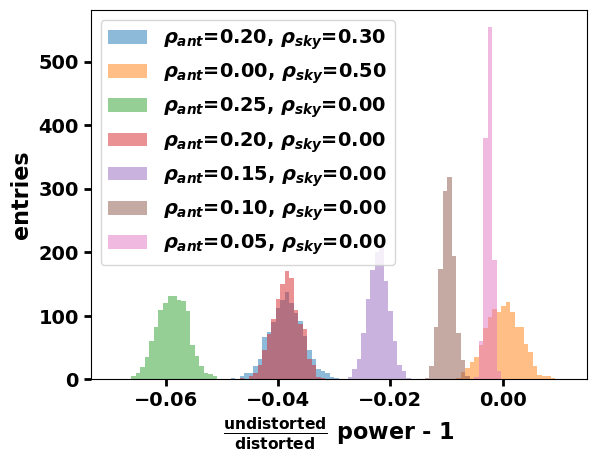

In [27]:
fig, ax = plt.subplots()

labels = [
    r"$\rho_{ant}$=0.20, $\rho_{sky}$=0.30",
    r"$\rho_{ant}$=0.00, $\rho_{sky}$=0.50",
    r"$\rho_{ant}$=0.25, $\rho_{sky}$=0.00",
    r"$\rho_{ant}$=0.20, $\rho_{sky}$=0.00",
    r"$\rho_{ant}$=0.15, $\rho_{sky}$=0.00",
    r"$\rho_{ant}$=0.10, $\rho_{sky}$=0.00",
    r"$\rho_{ant}$=0.05, $\rho_{sky}$=0.00",
]

bins = np.histogram_bin_edges(
    np.concatenate(
        [
            ratio_DF_1.values.flatten(),
            ratio_DF_3.values.flatten(),
            ratio_DF_2.values.flatten(),
            ratio_DF_2aa.values.flatten(),
            ratio_DF_2a.values.flatten(),
            ratio_DF_2b.values.flatten(),
            ratio_DF_2c.values.flatten(),
        ]
    ),
    bins=100,
)
bins -= 1
results = []

for i, df in enumerate(
    [
        ratio_DF_1,
        ratio_DF_3,
        ratio_DF_2,
        ratio_DF_2aa,
        ratio_DF_2a,
        ratio_DF_2b,
        ratio_DF_2c,
    ]
):
    ratios_power = df.values.flatten() - 1
    ax.hist(ratios_power, bins=bins, alpha=0.5, label=labels[i])
    stats = r"$\sigma$={:.1e}, $\mu$={:.3f}".format(
        np.abs(np.std(ratios_power)/np.mean(ratios_power)), round(np.mean(ratios_power), 2)+0
    )
    # print(labels[i] +',  '+ stats)
    temp = labels[i] + ",  " + stats
    numbers = re.findall(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?", temp)
    # print(numbers)
    results.append([float(i) for i in numbers])

ax.legend()
ax.set_xlabel(r"$\frac{\mathrm{undistorted}}{\mathrm{distorted}}$ power - 1")
ax.set_ylabel("entries")

s = (
    r"""| $\rho_{{ant}}$ | $\rho_{{sky}}$ | $\rho$  | $b$     |
|----------------|----------------|---------|---------|
| {:.2f}         | {:.2f}         | {:.1e}  | {:.2f}  |
| {:.2f}         | {:.2f}         | {:.1e}  | {:.2f}  |
| {:.2f}         | {:.2f}         | {:.1e}  | {:.2f}  |
| {:.2f}         | {:.2f}         | {:.1e}  | {:.2f}  |
| {:.2f}         | {:.2f}         | {:.1e}  | {:.2f}  |
| {:.2f}         | {:.2f}         | {:.1e}  | {:.2f}  |
| {:.2f}         | {:.2f}         | {:.1e}  | {:.2f}  |"""
).format(*np.asarray(results).flatten())

md(print("RESULTS:"))
md(s)

From the distributions above we see that:
    
- the error on the antenna gain is indeed causing a bias
- the propagated error is of order of $10^{-3}$ just like was analytically calculated

And from the color maps we learned that there is no LST or frequency correlation after propagating the error to the power.